## 1. Setup

### 1.1 install Dependencies

In [ ]:
# %pip install opencv-python tensorflow

### 1.2 Import Dependencies

In [1]:
# Import standard dependences
import cv2 
import os
import random 
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
# Import tensorflow dependences 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Flatten, Dense

### 1.3 Set GPU Growth

In [5]:
# Setup GPU memory consumption growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1.4 Create Folder Structure

In [6]:
# Setup paths 
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

## 2. Collect Positives and Anchors 

In [ ]:
import uuid # universally  unique identifier

In [ ]:
cap = cv2.VideoCapture("http://192.168.40.157:8000")

if not cap.isOpened():
    print("Error: Unable to open video stream.")
    exit()

while True:
    ret, frame = cap.read()
    frame = frame[250:250+250, 550:550+250, :]
    frame = cv2.flip(frame, 1)
    # Collect anchors 
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    #collect positives 
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0xFF == ord('c'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
frame.shape

## 3. Load and Preprocess Images
### 3.1 Get Image Directories

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [8]:
dir_test = anchor.as_numpy_iterator() 

In [10]:
dir_test.next()

b'data/anchor/b5945948-8985-11ef-80a4-00155d37f7cc.jpg'

### 3.2 Preprocessing - scale and resize

In [11]:
def preprocess(file_path):
    byte_image = tf.io.read_file(file_path)  # Read the image
    img = tf.io.decode_jpeg(byte_image) # Load the image
    # Preprocess steps - resizing image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # normalization
    img = img / 255.0
    return img

In [12]:
img = preprocess('data/anchor/255282c4-8985-11ef-80a4-00155d37f7cc.jpg')

In [13]:
img.numpy().min(), img.numpy().max()

(0.28112745, 0.71936274)

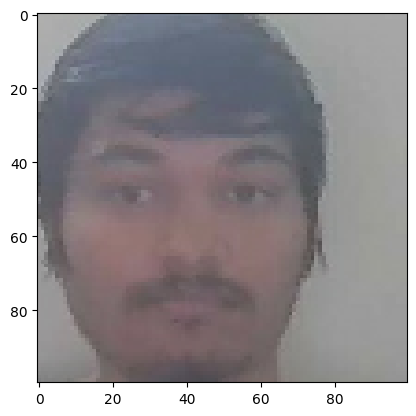

In [14]:
plt.imshow(img)

### 3.3 Create Labelled Dataset

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
samples = data.as_numpy_iterator()

In [17]:
example = samples.next()
example

(b'data/anchor/291e1ca6-8985-11ef-80a4-00155d37f7cc.jpg',
 b'data/positive/884c17ea-8986-11ef-80a4-00155d37f7cc.jpg',
 1.0)

### 3.4 Build Train and Test Partitions

In [18]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [19]:
res = preprocess_twin(*example)

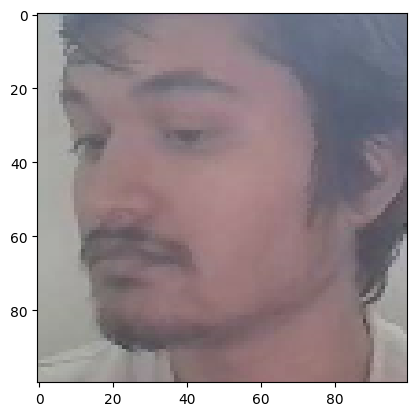

In [20]:
plt.imshow(res[1])

In [21]:
# Build dataloader pipeline 
data = data.map(preprocess_twin)
data = data.cache() 
data = data.shuffle(buffer_size=1024)

In [22]:
# Training partition 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
train_samples = train_data.as_numpy_iterator()

In [24]:
train_sample = train_samples.next()

In [25]:
# Testing partition 
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## 4. Model Engineering

### 4.1 Build Embedding Layer

In [31]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name="input_shape")
    
    # Block 1
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    # Block 2
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # Block 3
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # Final block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [32]:
embedding = make_embedding() 
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_shape (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Build Distance Layer

In [33]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        input_embedding = input_embedding[0] if isinstance(input_embedding, list) else input_embedding
        validation_embedding = validation_embedding[0] if isinstance(validation_embedding, list) else validation_embedding
        return tf.math.abs(input_embedding - validation_embedding)

### 4.3 Make Siamese Model 

In [34]:
def make_siamese_model():
    input_image = Input(shape=(100,100,3), name="input_image") # Anchor image
    validation_image = Input(shape=(100,100,3), name="val_image") # Validation image
    siamese_layer = L1Dist()
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')  

In [35]:
siamese_model = make_siamese_model() 
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ val_image           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ val_image[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Training

### 5.1 Setup Loss and Optimizer

In [36]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [37]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

### 5.2 Establish checkpoints

In [38]:
checkpoints_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoints_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### 5.3 Build Train Step Function

In [39]:
test_batch = train_data.as_numpy_iterator() 
batch_1 = test_batch.next()

In [40]:
batch_1[2]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [47]:
@tf.function 
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        # Forward pass 
        yhat = siamese_model(X, training=True)
        # Calculate loss 
        loss = binary_cross_loss(y, yhat)
    print(loss)
    # Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # Calculate updated weights and apply to siamese model 
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

### 5.4  Build Training Loop

In [48]:
def train(data, EPOCHS):
    # Loop through epochs 
    for epoch in range(1,EPOCHS+1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        # Loop through each batch
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        # Save Checkpoints 
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### 5.5 Train the model

In [49]:
EPOCHS = 100 

In [50]:
train(train_data, EPOCHS)


 Epoch 1/100
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)


2024-10-14 22:25:03.252360: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step

 Epoch 2/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

2024-10-14 22:25:06.946636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

 Epoch 3/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:25:08.440093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

 Epoch 4/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

2024-10-14 22:25:09.937427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

 Epoch 5/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

2024-10-14 22:25:11.434063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 6/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:25:12.926951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

 Epoch 7/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

2024-10-14 22:25:14.425147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

 Epoch 8/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:25:15.923861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 9/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:25:17.415045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 10/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

2024-10-14 22:25:18.905819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


2024-10-14 22:25:20.396331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step

 Epoch 12/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:25:24.344468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 13/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:25:25.823582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 14/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:25:27.232554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

 Epoch 15/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:25:28.614151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

 Epoch 16/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:25:30.004295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 17/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:25:31.395776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

 Epoch 18/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:25:31.744452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 19/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:25:33.151999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 20/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:25:34.552530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


2024-10-14 22:25:35.950321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 21/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 22/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:25:39.218241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 23/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:25:40.624076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 24/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:25:42.026945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 25/100
 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:25:43.422162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 26/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:25:44.817425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 27/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:25:46.219670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 28/100
 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:25:47.619500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 29/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:25:49.031517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 30/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:25:50.435234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


2024-10-14 22:25:51.839765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 31/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step

 Epoch 32/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:25:55.442460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 33/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:25:56.835347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 34/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:25:58.237075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 35/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:25:59.644154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 36/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:01.045909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 37/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:02.448393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

 Epoch 38/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:26:02.750916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 39/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:04.164022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 40/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:26:05.599540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


2024-10-14 22:26:07.023008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 41/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

 Epoch 42/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:11.923065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 43/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:13.322562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 44/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:14.724846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 45/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:16.127184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 46/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:26:17.533536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 47/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:26:18.955355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 48/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:26:20.366359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 49/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:26:21.794275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 50/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:26:23.222814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


2024-10-14 22:26:24.654107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 51/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

 Epoch 52/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:30.106879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 53/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:26:31.508440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 54/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:32.918311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 55/100
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

2024-10-14 22:26:34.332136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

 Epoch 56/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:34.713477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 57/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:26:36.164582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 58/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:26:37.609632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 59/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:26:39.048482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 60/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:40.495735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


2024-10-14 22:26:41.950674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 61/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

 Epoch 62/100
 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:26:47.244792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 63/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:26:48.659789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 64/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

2024-10-14 22:26:50.090966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 65/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:26:51.542481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 66/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:26:53.008808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 67/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:26:54.452263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 68/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:26:55.921998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 69/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:26:57.375773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 70/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:26:58.845467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


2024-10-14 22:27:00.296279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 71/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 

 Epoch 72/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:27:05.467784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 Epoch 73/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:27:06.877025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 74/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

2024-10-14 22:27:08.303391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 75/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:27:09.744330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 76/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:27:11.193731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 77/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:27:12.653710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 78/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:27:14.115615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 79/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:27:15.582087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 80/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:27:17.058317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


2024-10-14 22:27:18.540736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 81/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step

 Epoch 82/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:27:24.674964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 83/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:27:26.096860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 84/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:27:27.532633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 85/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:27:28.992128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 86/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

2024-10-14 22:27:30.450295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 87/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:27:31.918725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 88/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:27:33.384034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 89/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:27:34.863270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 90/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:27:36.341885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-10-14 22:27:36.749256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 91/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

 Epoch 92/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

2024-10-14 22:27:42.409167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 Epoch 93/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

2024-10-14 22:27:43.836628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 94/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:27:45.297772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Epoch 95/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

2024-10-14 22:27:46.765146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 96/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:27:48.244243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 97/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

2024-10-14 22:27:49.729193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 98/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

2024-10-14 22:27:51.210414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 99/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

2024-10-14 22:27:52.697033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 Epoch 100/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

2024-10-14 22:27:54.191509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


2024-10-14 22:27:55.701365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 6. Evaluate model

### 6.1 Metrics

In [51]:
from tensorflow.keras.metrics import Precision, Recall

In [88]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

### 6.2 Predictions

In [89]:
# Predictions 
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[1.9261357e-05],
       [5.9117215e-06],
       [1.0571684e-06],
       [1.0000000e+00],
       [9.9849081e-01],
       [1.0000000e+00],
       [1.9716861e-06],
       [9.9999988e-01],
       [9.9999988e-01],
       [9.9859089e-01],
       [9.9998903e-01],
       [4.9078517e-07],
       [1.2918279e-06],
       [6.0701450e-07],
       [9.9999964e-01],
       [1.2758185e-06]], dtype=float32)

In [90]:
# Post processing results 
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]

In [91]:
y_true

array([0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

### 6.3 Calculate Metrics

In [92]:
precision = Precision()
recall = Recall()
precision.update_state(y_true, y_hat)
recall.update_state(y_true, y_hat)
precision_result = precision.result().numpy()
recal_result = recall.result().numpy() 
print(f'Precision result: {precision_result} \nRecall result: {recal_result}')

Precision result: 1.0 
Recall result: 1.0


### 6.4 Visualize results 

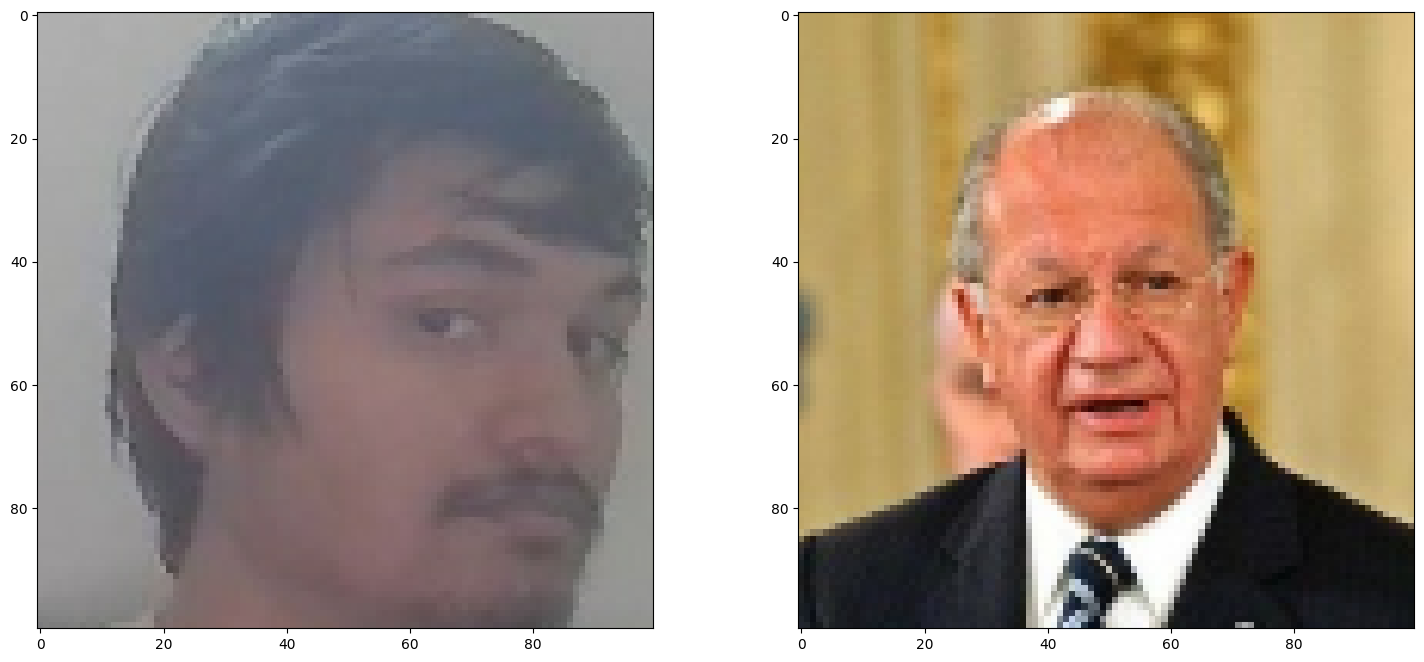

In [93]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[12])
plt.subplot(1,2,2)
plt.imshow(test_val[12])
plt.show()

## 7. Save Model

In [76]:
# save weights
siamese_model.save('siamesemodel.h5')

In [94]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                  custom_objects={'L1Dist': L1Dist, 
                                                  'BinaryCrossentropy': tf.keras.losses.BinaryCrossentropy})

In [95]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ val_image           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ val_image[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
y_test_hat = model.predict([test_input, test_val])
y_test_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[1.9261357e-05],
       [5.9117215e-06],
       [1.0571684e-06],
       [1.0000000e+00],
       [9.9849081e-01],
       [1.0000000e+00],
       [1.9716861e-06],
       [9.9999988e-01],
       [9.9999988e-01],
       [9.9859089e-01],
       [9.9998903e-01],
       [4.9078517e-07],
       [1.2918279e-06],
       [6.0701450e-07],
       [9.9999964e-01],
       [1.2758185e-06]], dtype=float32)

In [98]:
[1 if prediction > 0.5 else 0 for prediction in y_test_hat]

[0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]

In [99]:
y_true

array([0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

## 8. Real Time Test

### 8.1 Verification Function

In [119]:
def verify(model, detection_threshold, verification_threshold):
    results = [] 
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images', image))
         # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### 8.2 OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture("http://192.168.40.157:8000")

if not cap.isOpened():
    print("Error: Unable to open video stream.")
    exit()
    
while True:
    rest, frame = cap.read() 
    frame = frame[250:250+250, 550:550+250, :]
    frame = cv2.flip(frame, 1)
    cv2.imshow('verification', frame)
    # Verification trigger 
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        results, verified = verify(model, 0.8, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break 
        
cap.release() 
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━